# Projekt założenia
symulator zdarzeniowy M/M/1/N
    - średni czas oczekiwania na obsługę
    - prawdopobieństwo blokady
porównać zmodelem analitycznym:
    - dla N = 51
    - różnych wartości obciążenia: 0.01, 0.05, 0.1

średni czas oczekiwania - > histogram


In [15]:
# https://pyshark.com/poisson-distribution-and-poisson-process-in-python/#poisson-distribution-example-in-python
import scipy
import numpy as np
import matplotlib
from enum import Enum
import uuid

czas w serwerze to jest "usługa" 

In [16]:
import math
# global_time = 0
n = 51 # max order in a system
# zmienna lososowa opisująca czas między zgłoszeniami
la = 0.98 # 1.0478 # 0.977 #  # intensywność napływu
# time_between_packet = 1 / la
# zmienna losowa opisuje czas pomiędzy zgłoszeniami k przez serwer
mu = 1
# time_of_service = 1 / mu # intensywność obsługi
time_of_simulation = 10000
seed_val =1

# https://github.com/amasl2048/queue-mm1/blob/master/qtest.cpp
roh = la / mu
rn = pow(roh, n + 1)
p0 = (1 - roh) / (1 - rn)         # free queue probability
pb = p0 * rn / roh                

navg = roh / (1-roh) - (n+1) * rn/(1-rn)  
tavg = navg / la                    
u    = mu * (1 - p0)                

out = '''
pb   = %.4f    # block probability
navg = %.4f    # average orders in a system
tavg = %.4f    # average time in a system
u    = %.4f    # throughput
'''
print(out % (pb, navg, tavg, u))

avr_queue = (roh * (1 + roh ** n * (n * roh - (n + 1))))/ (mu * ( 1 - roh) * (1 - roh * (roh ** (n+2))))
print(f"average time in queue: {avr_queue}")
problock = roh ** (n + 1) * ( 1 - roh) / (1 - roh ** (n + 2))
print(f"probability of block: {problock}")


pb   = 0.0110    # block probability
navg = 21.0309    # average orders in a system
tavg = 21.4601    # average time in a system
u    = 0.9692    # throughput

average time in queue: 20.59232772277444
probability of block: 0.010642844302829326


In [17]:
class EventType(Enum):
    IN_EVENT = "IN_EVENT"
    OUT_EVENT = "OUT_EVENT"

# slajd 91, 

class Event():
    def __init__(self, time: float, event_type, client_id = None):
        self.time = time
        self.event_type = event_type
        if client_id == None:
            self.client_id = str(uuid.uuid4())
        else:
            self.client_id = client_id
    
    def __str__(self):
        mes = f"{self.client_id}, {self.event_type}, {self.time}"
        return mes
    
    def set_time_in_queue(self, time_in_queue):
        self.time_in_queue = time_in_queue
    
    def get_event_stats(self):
        return {
            'oc_time': self.time,
            # 'qu_time': self.time_in_queue,
            'client_id': self.client_id,
            'event_type': self.event_type
        }

In [18]:
class Server:
    def __init__(self):
        self.all_clients =0 
        self.all_clients_in_queue = 0
        self.client_in_server = False
        self.clients_number_in_queue = 0 
        self.client_in_server = None
        self.clients_in_queue = []
        self.buffor = n
    
    def get_server_stats(self):
        return self.client_in_server, self.clients_number_in_queue

    def is_server_empty(self):
        return not self.client_in_server

    def is_queue_empty(self):
        return not self.clients_in_queue

    def is_place_for_new_event(self):
        return self.clients_number_in_queue + 1 <= self.buffor

    def add_client_to_server(self, client_id, timestamp):
        self.all_clients += 1
        self.client_in_server = True
        self.clients_in_server = (client_id, timestamp)

    def add_client_to_queue(self, client_id, timestamp):
        self.all_clients_in_queue += 1
        self.clients_number_in_queue += 1
        self.clients_in_queue.insert(0, (client_id, timestamp))

    def get_queue_first_client(self):
        return self.clients_in_queue[-1]

    """
    def delete_client_from_queue(self):
        self.clients_number_in_queue -= 1
        self.clients_in_queue.pop(0)
    
    """
    def delete_client_from_queue(self, client_id):
        self.clients_number_in_queue -= 1
        self.clients_in_queue = list(
            filter(
                lambda client: client[0] != client_id,
                self.clients_in_queue))
    
    def delete_client_from_server(self):
        self.client_in_server = False
        self.client_in_server = None




In [19]:
import time




class Simulation:
    def __init__(self):
        # marge
        self.events = []
        self.clients_stats = []
        self.server = Server()
        self.clients = 0 
        self.current_time = 0 


    def handle_events(self):
        while self.events:
            current_event = self.events.pop()
            current_time = current_event.time
            print(current_event)
            # print(self.server.is_place_for_new_event())
            # print(current_event, self.server.clients_in_queue, not self.server.is_queue_empty())
            # print(len(self.events))
            # check buffor, time in queue
            if current_event.event_type == EventType.IN_EVENT:
                if self.server.is_server_empty():
                    self.server.add_client_to_server(current_event.client_id, current_time)
                    self.events.append(Event(current_time + self.generate_service(),  EventType.OUT_EVENT, current_event.client_id))
                    print("event in server")
                else:
                    if self.server.is_place_for_new_event():
                        print("event added to queue")
                        self.server.add_client_to_queue(current_event.client_id, current_time)
                    else:
                        pass
                        print("packet dropped")
            if current_event.event_type == EventType.OUT_EVENT:
                self.server.delete_client_from_server()
                self.clients -= 1
                time_in_server = self.generate_service()
                # print(time_in_server)
                if not self.server.is_queue_empty():
                    # print("Server bussy")
                    # print(self.server.get_queue_first_client())
                    client_id, client_time = self.server.get_queue_first_client()
                    self.server.delete_client_from_queue(client_id)
                    new_event = Event(current_time + time_in_server, EventType.OUT_EVENT, client_id=client_id)
                    new_event.set_time_in_queue(current_time - client_time)
                    self.events.append(new_event)
                    self.clients_stats.append(new_event.time_in_queue)
            self.events = self.sort_events()
        
    def init_events(self):
        occurrence_time = 0
        while occurrence_time < time_of_simulation:
            event_occurance = self.generate_interarrival()
            occurrence_time += event_occurance
            new_event = Event(
                event_occurance,
                EventType.IN_EVENT
                )
            self.events.append(new_event)
        self.events = self.sort_events()
        self.clients = len(self.events)
        print(self.clients)
        
    def run_simulation(self):
        self.init_events()
        self.handle_events()
    
    def generate_interarrival(self):
        return np.random.exponential(la)
    
    def generate_service(self):
        return np.random.exponential(mu)

    def sort_events(self):
        return sorted(
                self.events,
                key=lambda time: getattr(time, 'time'),
                reverse= True)
sim = Simulation()
sim.run_simulation()

10314
0.6704717073368158
3.793213148559887
0.12035329613802348
0.8567511689875387
1.457480390772158
0.091258916282536
0.5802329073557717
1.961420931010101
1.1905106105671137
3.185830056856819
1.0928903744574145
0.23637612560173893
0.3484736075404741
1.1834797784352873
1.2528372840086943
2.0627570064653957
1.3757949834027798
1.1519707540551987
0.6203077468628908
0.5439802381696462
1.764120103741548
3.992382017488754
1.7132234241306386
0.896809837149637
0.037975448083519756
1.5064381020175317
0.2989305811274806
0.7214181123668798
1.6322069431524342
0.9631997815058589
1.8440796502913743
2.026006089905953
0.035466438408472495
0.3290135642269788
2.971241942342244
0.614298899528291
0.13151546383192
1.024418119445069
1.3334292599774258
0.8042205545977188
0.8264671770477445
2.8763278324566026
0.2881461360853984
0.26846120822479097
4.525497438502081
0.5996279960569778
3.3860107770389996
2.7532320591900463
1.010905767972393
0.14603620905600076
1.02356075278078
0.729804496100401
0.873333278120912

In [20]:
# statistics
np.random.seed(seed_val)
sim = Simulation()
sim.run_simulation()
# print(sim.clients)
all_time_in_queue = 0
pakiets_in_queue = 0
for idx,  time_in_queue in enumerate(sim.clients_stats):
    print(time_in_queue)
    all_time_in_queue += time_in_queue
    pakiets_in_queue += 1
all_time_in_queue/pakiets_in_queue

10311
0.764467928149024
5.214121328962962
0.29618580022680835
0.5463697278121707
2.594611261623734
0.018581352315803466
0.6282089707343967
0.02318708341523592
1.1734851302651714
0.1387520387587677
0.29492600258281837
0.5468447010160749
1.060025925944661
0.7136933316856134
0.8347406814147911
1.8878553793939141
0.7347533736640726
0.5709302029035243
0.439883509570006
2.8130978064513146
0.9456860922586865
0.08471086129189968
0.6959178053190824
0.7861774289200505
1.1305147679818786
0.23966677548099674
1.4877280714341863
0.6285123335991039
0.11175667196617536
1.1784459343352873
0.8325925156842235
0.057561987237946234
0.15201608219555912
2.998237824673758
0.48337717801929914
2.4591479677259613
1.273142371886758
0.7720445558979764
0.5712066082213515
2.0451677582013947
1.422303163984854
0.612897776215429
0.3671475258626256
0.6325339499455955
0.3695582964953867
2.2804282721176343
0.5450804328176199
0.8515277617714866
0.28473110525773343
0.3906053065818054
2.5801374189791737
0.9145071684264354
0.

1.9322524136636992

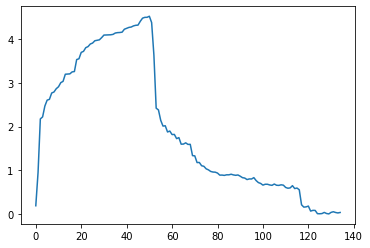

In [21]:
import matplotlib.pyplot as plt
plt.plot(sim.clients_stats)

get pobiera zdarzenie z listy z namnijeszym czasem, przesuwa czas symulacji do tego czasu

To do: 
- czy ten exmpnetial jest dobry aby na pewno to possion? 
- zrobić historgram dla b
- sprawko 
- wysłać

UAKTUALNIENIE: ponieważ w punkcie III projektu wkradł się błąd a jest już blisko terminu oddania prac, proszę wykonać tę część przy prostym założeniu, że odstęp miedzy przychodzącymi klientami jest stały i równy średniej z punktu I. 
Reference materials